In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

<Client: 'tcp://127.0.0.1:44835' processes=2 threads=2, memory=9.00 GiB>

In [3]:
def regrid_ACCESS(ds, var):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [4]:
#load in ctrl dataset
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl = regrid_ACCESS(ctrl_sst, 'sst')
ctrl = ctrl.compute()

In [5]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    df = df.sortby(df.longitude)
    return df

In [6]:
ctrl = roll_lon(ctrl)

In [7]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
    return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO3(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(210, 270)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(190, 240)).mean(['latitude', 'longitude'])
def NINO4(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(160, 210)).mean(['latitude', 'longitude'])
def DMI(DS):
    WTIO =  ssta(DS).sel(latitude=slice(
         -10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO =  ssta(DS).sel(latitude=slice(
         -10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO - SETIO)

In [8]:
def Modoki(DS):
    boxa = ssta(DS).sel(latitude=slice(
        -10, 10),longitude=slice(165, 220)).mean(['latitude', 'longitude'])
    boxb = ssta(DS).sel(latitude=slice(
        -15, 5),longitude=slice(250, 290)).mean(['latitude', 'longitude'])
    boxc = ssta(DS).sel(latitude=slice(
        -10, 20),longitude=slice(125, 145)).mean(['latitude', 'longitude'])
    return (boxa - (0.5*boxb) - (0.5*boxc))

In [9]:
n3 = NINO3(ctrl)
n34 = NINO34(ctrl)
n4 = NINO4(ctrl)

In [10]:
mod = Modoki(ctrl)

In [11]:
dmi = DMI(ctrl)

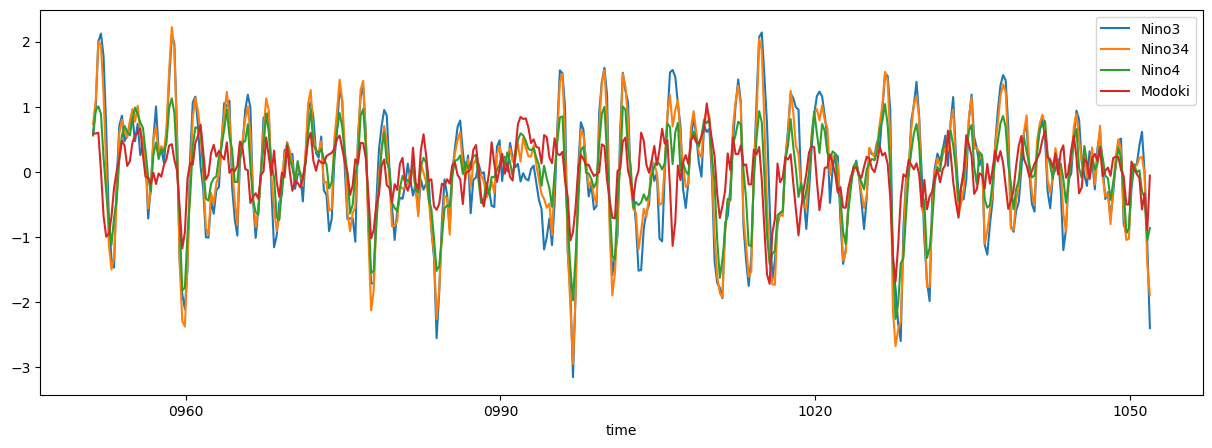

In [12]:
plt.figure(figsize = (15,5))
n3.resample(time='QS-DEC').mean(dim="time").sel(time = slice("0951-01-01", "1051-12-31")).plot(label = "Nino3")
n34.resample(time='QS-DEC').mean(dim="time").sel(time = slice("0951-01-01", "1051-12-31")).plot(label = "Nino34")
n4.resample(time='QS-DEC').mean(dim="time").sel(time = slice("0951-01-01", "1051-12-31")).plot(label = "Nino4")
mod.resample(time='QS-DEC').mean(dim="time").sel(time = slice("0951-01-01", "1051-12-31")).plot(label = "Modoki")
plt.legend()

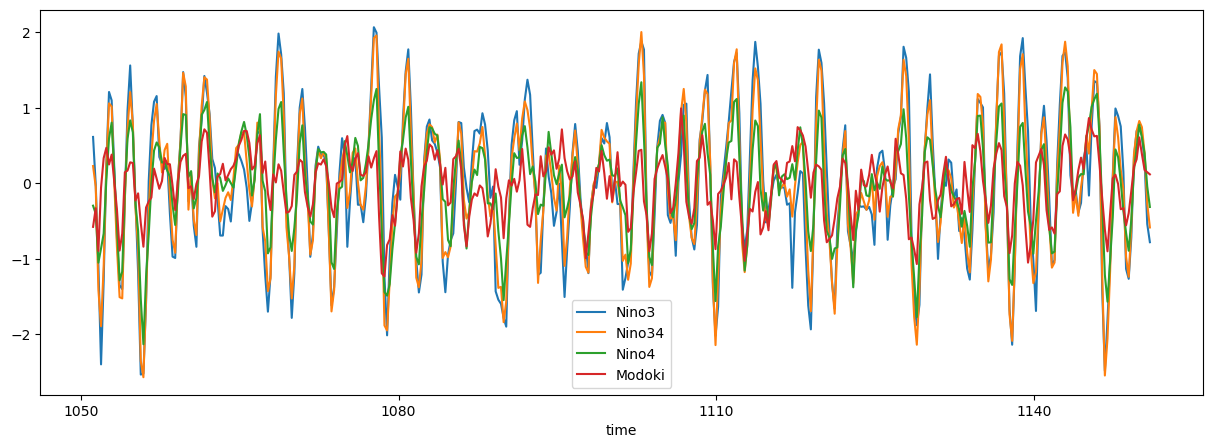

In [13]:
plt.figure(figsize = (15,5))
n3.resample(time='QS-DEC').mean(dim="time").sel(time = slice("1051-01-01", "1151-12-31")).plot(label = "Nino3")
n34.resample(time='QS-DEC').mean(dim="time").sel(time = slice("1051-01-01", "1151-12-31")).plot(label = "Nino34")
n4.resample(time='QS-DEC').mean(dim="time").sel(time = slice("1051-01-01", "1151-12-31")).plot(label = "Nino4")
mod.resample(time='QS-DEC').mean(dim="time").sel(time = slice("1051-01-01", "1151-12-31")).plot(label = "Modoki")
plt.legend()

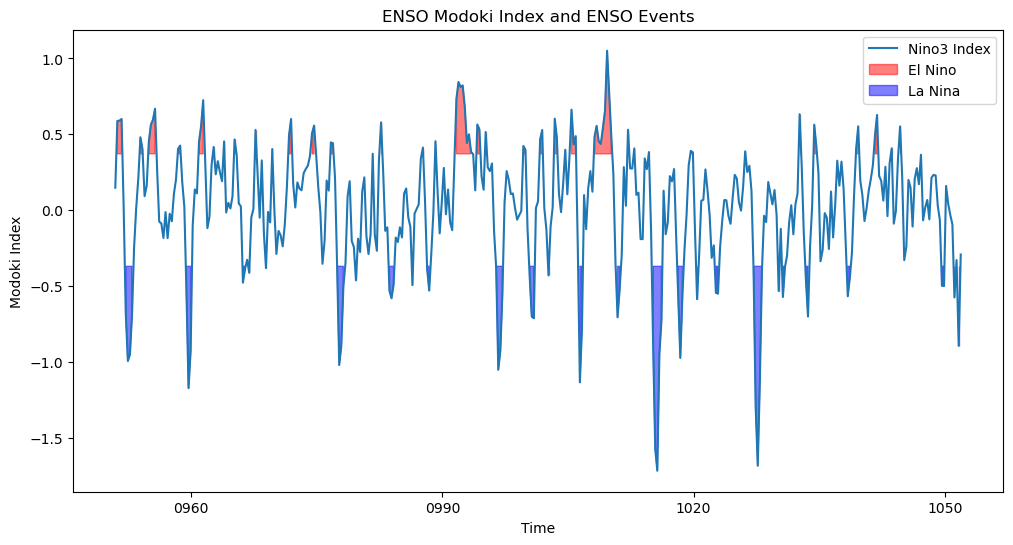

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
QS = mod.sel(time = slice("0951-01-01", "1051-12-31")).resample(time='QS-DEC').mean(dim="time")
#select SON seasons into a timeseries
threshold = QS.groupby('time.season')["DJF"].std().values

# Plot the Nino3 index as a line plot
QS.plot.line(ax=ax, label='Nino3 Index')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS['time'].values, threshold, QS, where=QS >= threshold, color='red', alpha=0.5, label='El Nino')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS['time'].values, -threshold, QS, where=QS <= -threshold, color='blue', alpha=0.5, label='La Nina')
# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Modoki Index')
ax.set_title('ENSO Modoki Index and ENSO Events')

# Add a legend
ax.legend()

In [14]:
#normalise timeseires
def normalise(da):
    # Step 1: Find the absolute maximum value
    abs_max_value = abs(da).max()

    # Step 2: Normalize the values to [-1, 1] by dividing by the absolute maximum value
    normalized_data = da / abs_max_value
    return normalized_data

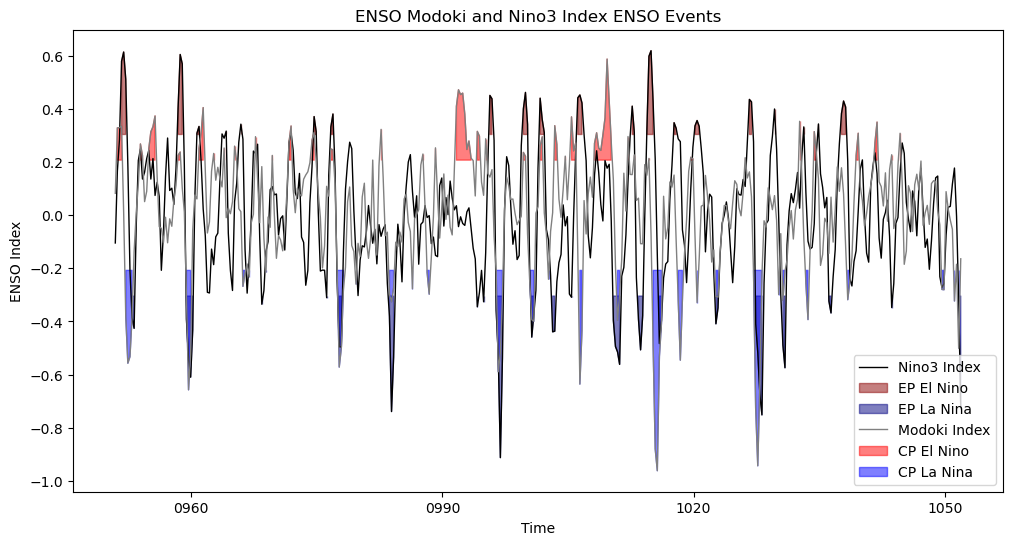

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

QS = normalise(n3).sel(time = slice("0951-01-01", "1051-12-31")).resample(time='QS-DEC').mean(dim="time")
#select SON seasons into a timeseries
threshold = QS.groupby('time.season')["DJF"].std().values

# Plot the Nino3 index as a line plot
QS.plot.line(ax=ax, c = 'k', linewidth = 1,  label='Nino3 Index')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS['time'].values, threshold, QS, where=QS >= threshold, color='darkred', alpha=0.5, label='EP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS['time'].values, -threshold, QS, where=QS <= -threshold, color='navy', alpha=0.5, label='EP La Nina')
# Set labels and title
ax.set_xlabel('Time')

QS = normalise(mod).sel(time = slice("0951-01-01", "1051-12-31")).resample(time='QS-DEC').mean(dim="time")
#select SON seasons into a timeseries
threshold = QS.groupby('time.season')["DJF"].std().values

# Plot the Nino3 index as a line plot
QS.plot.line(ax=ax, c = 'gray', linewidth = 1, label='Modoki Index')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS['time'].values, threshold, QS, where=QS >= threshold, color='red', alpha=0.5, label='CP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS['time'].values, -threshold, QS, where=QS <= -threshold, color='blue', alpha=0.5, label='CP La Nina')
# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('ENSO Index')
ax.set_title('ENSO Modoki and Nino3 Index ENSO Events')

# Add a legend
ax.legend()



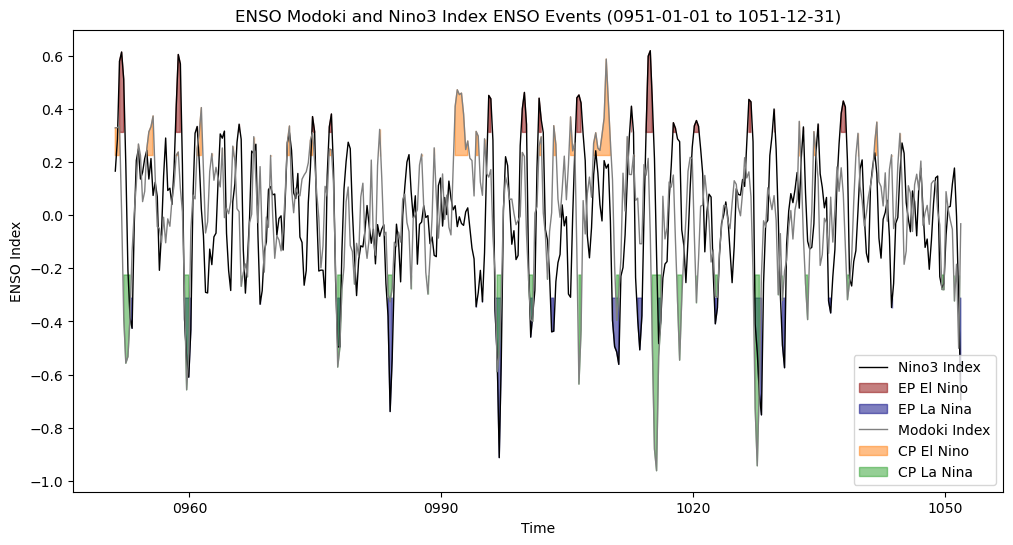

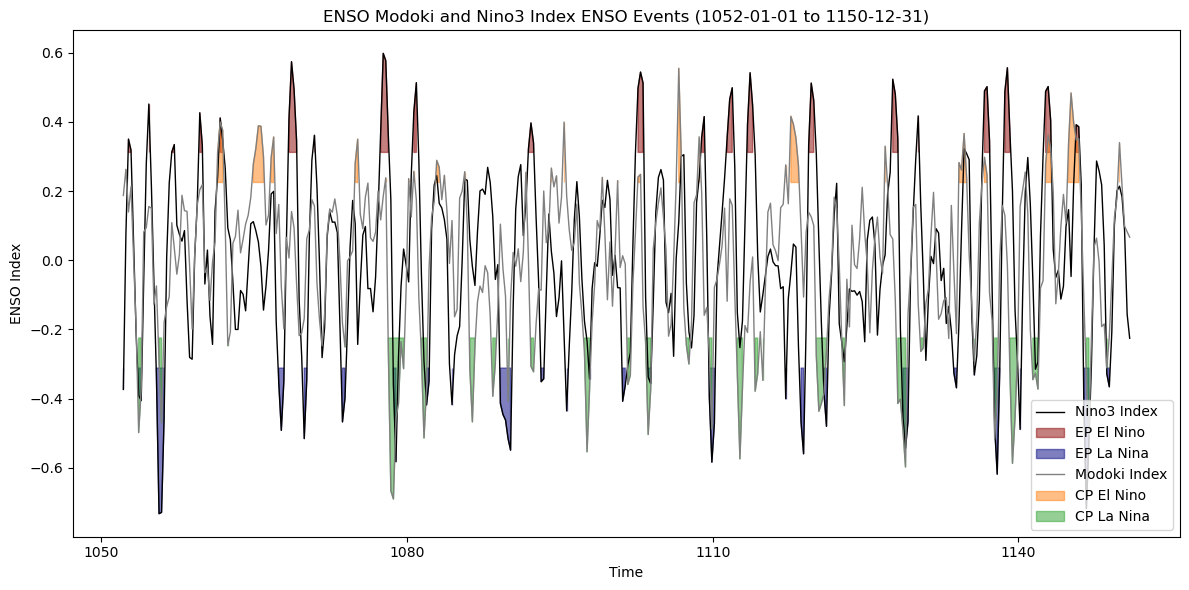

In [31]:
#normalise indexes as 3monthly
QS = normalise(n3).resample(time='QS-DEC').mean(dim="time")
QS2 = normalise(mod).resample(time='QS-DEC').mean(dim="time")
TQ = QS.groupby('time.season')["DJF"].std().values
TQ2 = QS2.groupby('time.season')["DJF"].std().values
#divide into 2 periods

QS1 = QS.sel(time=slice("0951-01-01", "1051-12-31"))
QS12 = QS.sel(time=slice("1052-01-01", "1150-12-31"))

QS21 = QS2.sel(time=slice("0951-01-01", "1051-12-31"))
QS22 = QS2.sel(time=slice("1052-01-01", "1150-12-31"))

# Create the first subplot (above)
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the Nino3 index as a line plot
QS1.plot.line(ax=ax,c = 'k', linewidth = 1, label='Nino3 Index')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS1['time'].values, TQ, QS1, where=QS1 >= TQ, color='darkred', alpha=0.5, label='EP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS1['time'].values, -TQ, QS1, where=QS1 <= -TQ, color='navy', alpha=0.5, label='EP La Nina')


# Plot the Nino3 index as a line plot
QS21.plot.line(ax=ax,c = 'gray', linewidth = 1, label='Modoki Index')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS21['time'].values, TQ2, QS21, where=QS21 >= TQ2, color='tab:orange', alpha=0.5, label='CP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS21['time'].values, -TQ2, QS21, where=QS21 <= -TQ2, color='tab:green', alpha=0.5, label='CP La Nina')


# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('ENSO Index')
ax.set_title('ENSO Modoki and Nino3 Index ENSO Events (0951-01-01 to 1051-12-31)')

# Add a legend
ax.legend()

# Create the second subplot (below)
fig, ax2 = plt.subplots(figsize=(12, 6))

# Plot the Nino3 index as a line plot
QS12.plot.line(ax=ax2, c = 'k', linewidth = 1,label='Nino3 Index')

# Fill the area above the threshold (El Nino events)
ax2.fill_between(QS12['time'].values, TQ, QS12, where=QS12 >= TQ, color='darkred', alpha=0.5, label='EP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax2.fill_between(QS12['time'].values, -TQ, QS12, where=QS12 <= -TQ, color='navy', alpha=0.5, label='EP La Nina')

# Plot the Nino3 index as a line plot
QS22.plot.line(ax=ax2, c = 'gray', linewidth = 1,label='Modoki Index')

# Fill the area above the threshold (El Nino events)
ax2.fill_between(QS22['time'].values, TQ2, QS22, where=QS22 >= TQ2, color='tab:orange', alpha=0.5, label='CP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax2.fill_between(QS22['time'].values, -TQ2, QS22, where=QS22 <= -TQ2, color='tab:green', alpha=0.5, label='CP La Nina')


# Set labels and title for the second subplot
ax2.set_xlabel('Time')
ax2.set_ylabel('ENSO Index')
ax2.set_title('ENSO Modoki and Nino3 Index ENSO Events (1052-01-01 to 1150-12-31)')

# Add a legend for the second subplot
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show both subplots
plt.show()


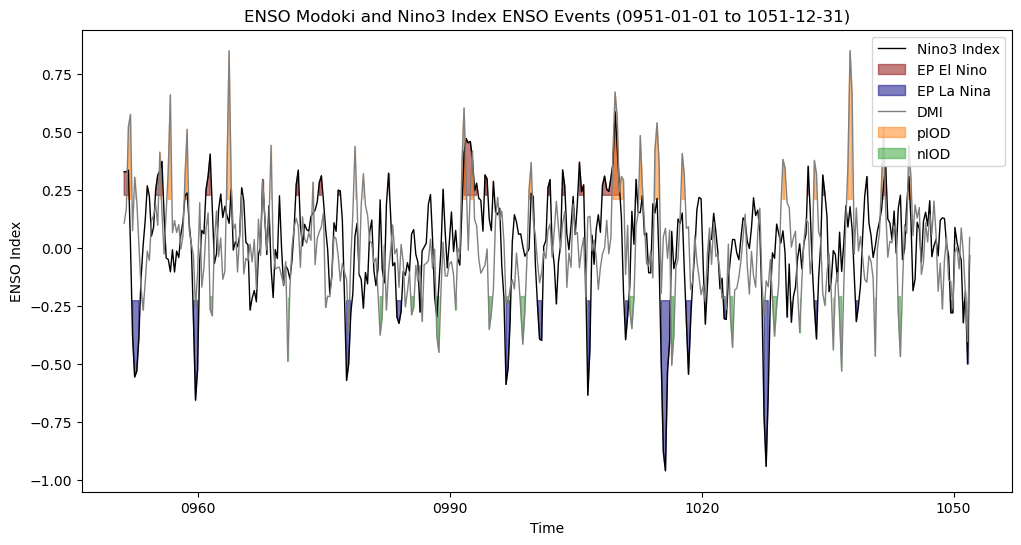

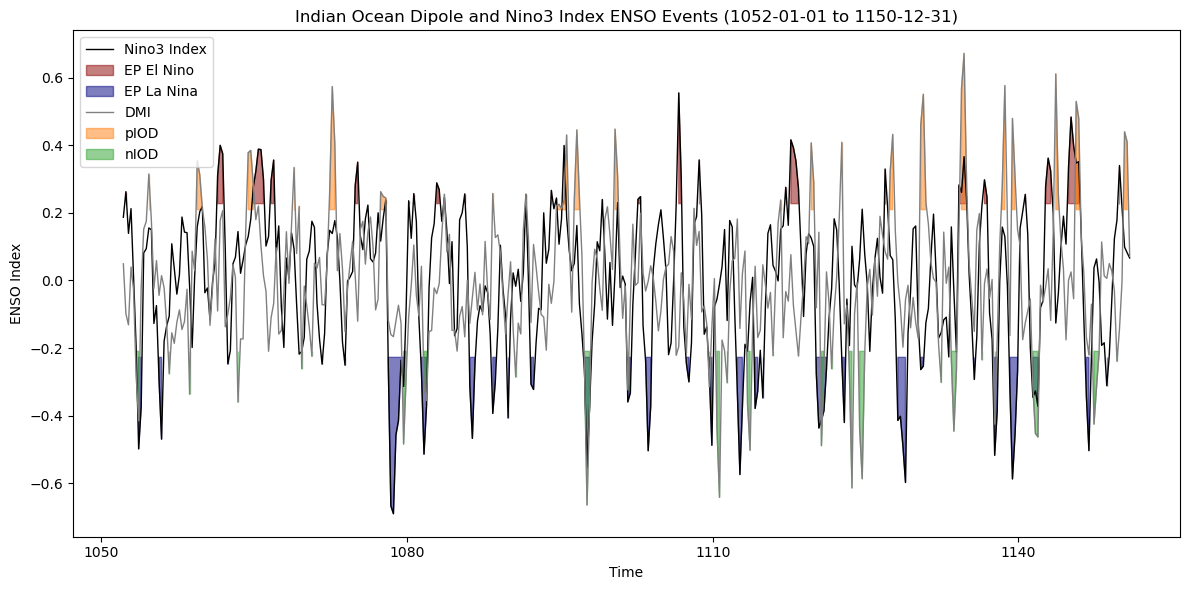

In [68]:
#normalise indexes as 3monthly
QS = normalise(mod).resample(time='QS-DEC').mean(dim="time")
QS2 = normalise(dmi).resample(time='QS-DEC').mean(dim="time")
TQ = QS.std().values#.groupby('time.season')["DJF"].std().values
TQ2 = QS2.std().values#.groupby('time.season')["SON"].std().values
#divide into 2 periods

QS1 = QS.sel(time=slice("0951-01-01", "1051-12-31"))
QS12 = QS.sel(time=slice("1052-01-01", "1150-12-31"))

QS21 = QS2.sel(time=slice("0951-01-01", "1051-12-31"))
QS22 = QS2.sel(time=slice("1052-01-01", "1150-12-31"))

# Create the first subplot (above)
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the Nino3 index as a line plot
QS1.plot.line(ax=ax,c = 'k', linewidth = 1, label='Nino3 Index')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS1['time'].values, TQ, QS1, where=QS1 >= TQ, color='darkred', alpha=0.5, label='EP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS1['time'].values, -TQ, QS1, where=QS1 <= -TQ, color='navy', alpha=0.5, label='EP La Nina')


# Plot the Nino3 index as a line plot
QS21.plot.line(ax=ax,c = 'gray', linewidth = 1, label='DMI')

# Fill the area above the threshold (El Nino events)
ax.fill_between(QS21['time'].values, TQ2, QS21, where=QS21 >= TQ2, color='tab:orange', alpha=0.5, label='pIOD')

# Fill the area below the negative threshold (La Nina events)
ax.fill_between(QS21['time'].values, -TQ2, QS21, where=QS21 <= -TQ2, color='tab:green', alpha=0.5, label='nIOD')


# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('ENSO Index')
ax.set_title('ENSO Modoki and Nino3 Index ENSO Events (0951-01-01 to 1051-12-31)')

# Add a legend
ax.legend()

# Create the second subplot (below)
fig, ax2 = plt.subplots(figsize=(12, 6))

# Plot the Nino3 index as a line plot
QS12.plot.line(ax=ax2, c = 'k', linewidth = 1,label='Nino3 Index')

# Fill the area above the threshold (El Nino events)
ax2.fill_between(QS12['time'].values, TQ, QS12, where=QS12 >= TQ, color='darkred', alpha=0.5, label='EP El Nino')

# Fill the area below the negative threshold (La Nina events)
ax2.fill_between(QS12['time'].values, -TQ, QS12, where=QS12 <= -TQ, color='navy', alpha=0.5, label='EP La Nina')

# Plot the Nino3 index as a line plot
QS22.plot.line(ax=ax2, c = 'gray', linewidth = 1,label='DMI')

# Fill the area above the threshold (El Nino events)
ax2.fill_between(QS22['time'].values, TQ2, QS22, where=QS22 >= TQ2, color='tab:orange', alpha=0.5, label='pIOD')

# Fill the area below the negative threshold (La Nina events)
ax2.fill_between(QS22['time'].values, -TQ2, QS22, where=QS22 <= -TQ2, color='tab:green', alpha=0.5, label='nIOD')


# Set labels and title for the second subplot
ax2.set_xlabel('Time')
ax2.set_ylabel('ENSO Index')
ax2.set_title('Indian Ocean Dipole and Nino3 Index ENSO Events (1052-01-01 to 1150-12-31)')

# Add a legend for the second subplot
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show both subplots
plt.show()


In [12]:
def events(ds, peak_seas):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = ds.resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    seas = QS.groupby('time.season')[peak_seas]
    #now use this to select all events and create da's of niod and piod event values
    threshold = seas.std()
    
    lower,upper = seas.quantile([0.2, 0.8])
    
    
    LN = seas.where(seas <= -threshold).dropna(dim = "time")
    EN = seas.where(seas >= threshold).dropna(dim = "time")
    return LN, EN


In [16]:
niod, piod = events(dmi, 'SON')

In [17]:
lm, em = events(mod, "DJF")

In [18]:
l3, e3 = events(n3, "DJF")

In [19]:
l34, e34 = events(n34, "DJF")

In [20]:
e3_emod=[]
for year in e3.groupby("time.year").mean("time").year.values:
    if year in em.groupby("time.year").mean("time").year.values:
        e3_emod.append(year)
print(e3_emod)

[960, 976, 1001, 1061, 1077, 1102, 1136, 1142, 1145]


In [21]:
l3_lmod=[]
for year in l3.groupby("time.year").mean("time").year.values:
    if year in lm.groupby("time.year").mean("time").year.values:
        l3_lmod.append(year)
print(l3_lmod)

[952, 959, 977, 983, 996, 1000, 1010, 1015, 1022, 1027, 1053, 1055, 1073, 1078, 1081, 1089, 1097, 1103, 1109, 1120, 1128, 1137, 1146]


In [22]:
em.groupby("time.year").mean("time").year.values

array([ 953,  954,  960,  963,  971,  976,  991,  992, 1001, 1005, 1008,
       1009, 1012, 1041, 1061, 1064, 1065, 1066, 1074, 1077, 1082, 1102,
       1106, 1117, 1126, 1134, 1136, 1142, 1144, 1145, 1149])

In [23]:
#get the years of only CP and only EP ENSO
CP_e = [item for item in em.groupby("time.year").mean("time").year.values if item not in e3_emod]
CP_e = xr.DataArray(CP_e, coords={'year': CP_e}, dims=['year'])

In [24]:
CP_l = [item for item in lm.groupby("time.year").mean("time").year.values if item not in l3_lmod]
CP_l = xr.DataArray(CP_l, coords={'year': CP_l}, dims=['year'])

In [25]:
EP_l = [item for item in l3.groupby("time.year").mean("time").year.values if item not in l3_lmod]
EP_l = xr.DataArray(EP_l, coords={'year': EP_l}, dims=['year'])

In [26]:
EP_e = [item for item in e3.groupby("time.year").mean("time").year.values if item not in e3_emod]
EP_e = xr.DataArray(EP_e, coords={'year': EP_e}, dims=['year'])

In [27]:
#get SSTA

In [28]:
STA = ssta(ctrl)
#and process to get DJF and SON compoistes with time dim in years
STA = STA.resample(time='QS-DEC').mean(dim="time")
STA_DJF = STA.groupby('time.season')["DJF"]
STA_SON = STA.groupby('time.season')["SON"]
STA_DJF = STA_DJF.groupby("time.year").mean("time")
STA_SON = STA_SON.groupby("time.year").mean("time")

In [29]:
CPl_SON = STA_SON.where(STA_SON.year == CP_l.year)#.dropna(dim = "time")
CPl_DJF = STA_DJF.where(STA_DJF.year == CP_l.year)#.dropna(dim = "time")
CPe_SON = STA_SON.where(STA_SON.year == CP_e.year)#.dropna(dim = "time")
CPe_DJF = STA_DJF.where(STA_DJF.year == CP_e.year)#.dropna(dim = "time")


In [30]:
EPl_SON = STA_SON.where(STA_SON.year == EP_l.year)#.dropna(dim = "time")
EPl_DJF = STA_DJF.where(STA_DJF.year == EP_l.year)#.dropna(dim = "time")
EPe_SON = STA_SON.where(STA_SON.year == EP_e.year)#.dropna(dim = "time")
EPe_DJF = STA_DJF.where(STA_DJF.year == EP_e.year)#.dropna(dim = "time")


In [31]:
def plot_comp(da, title):
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    da.mean("year").plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                            vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
    ax.set_title(title)
    ax.coastlines(color = 'k')
    ax.gridlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    return

In [32]:
def plot_comp(da, title, subplot_index):
    # Define the subplot layout (2 rows, 2 columns)
    plt.subplot(2, 2, subplot_index, projection=ccrs.PlateCarree(central_longitude=180))
    
    da.mean("year").plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r")
    
    plt.title(title)
    plt.gca().coastlines(color='k')
    plt.gca().gridlines()
    plt.gca().set_facecolor('grey')
    gl = plt.gca().gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False



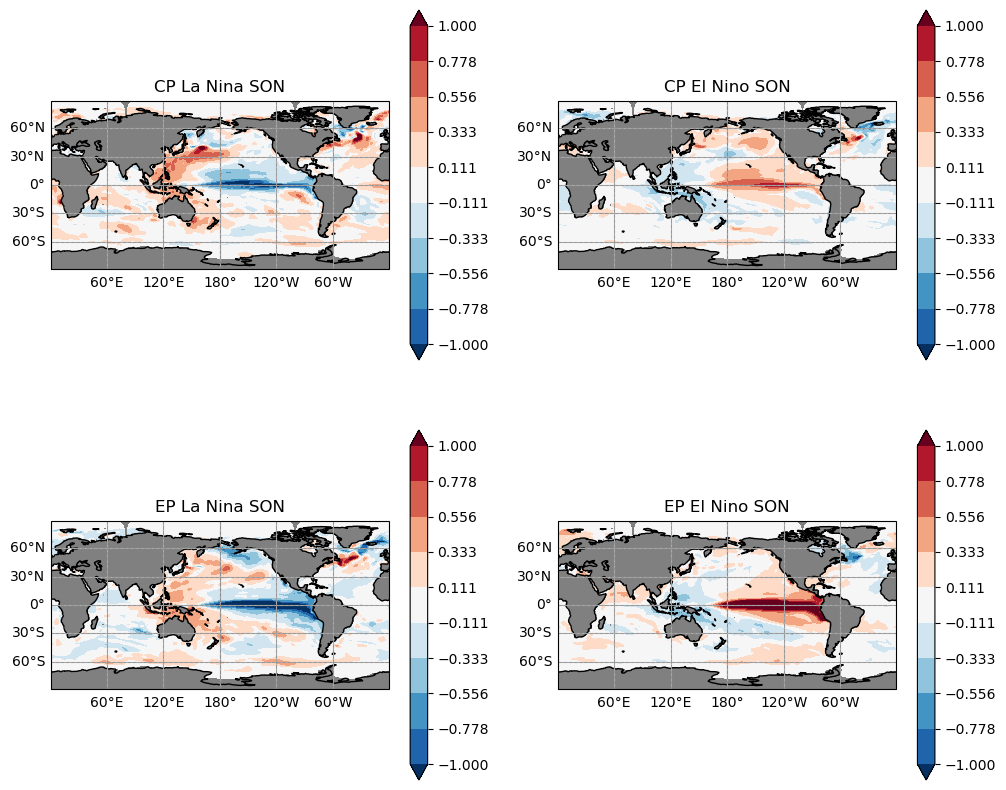

In [33]:
# Create a figure with 4 subplots
fig = plt.figure(figsize=(12, 10))

# Call the function for each subplot
plot_comp(CPl_SON, "CP La Nina SON", 1) 
plot_comp(CPe_SON, "CP El Nino SON", 2) 
plot_comp(EPl_SON, "EP La Nina SON", 3) 
plot_comp(EPe_SON, "EP El Nino SON", 4) 

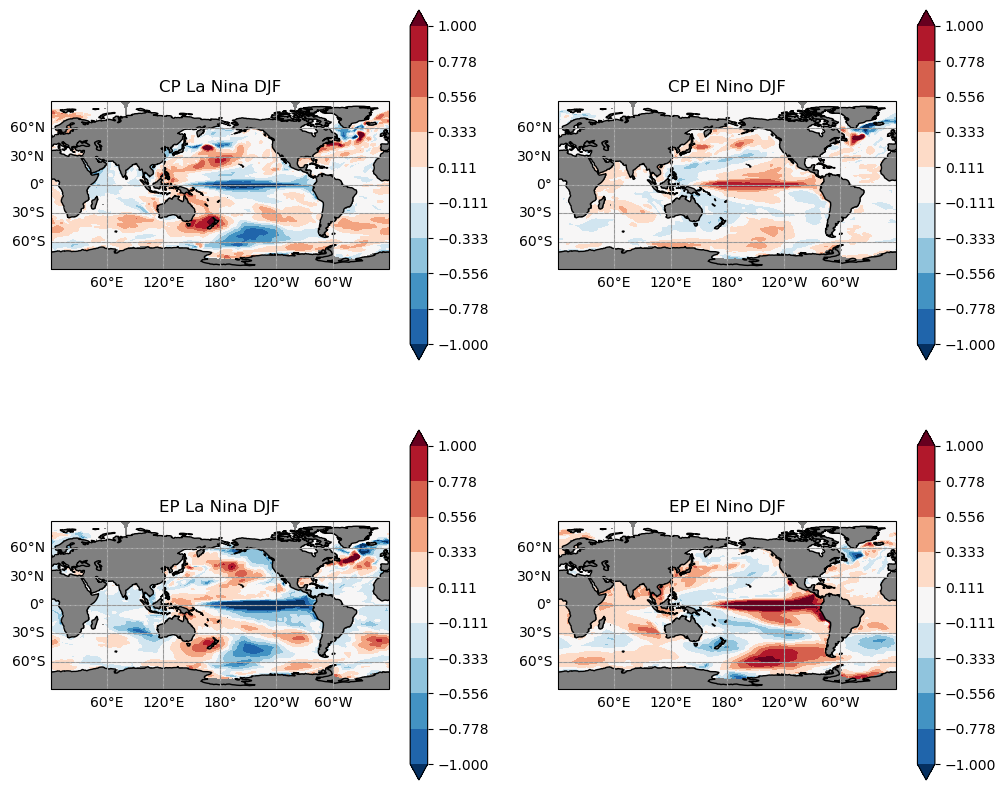

In [34]:
# Create a figure with 4 subplots
fig = plt.figure(figsize=(12, 10))

# Call the function for each subplot
plot_comp(CPl_DJF, "CP La Nina DJF", 1) 
plot_comp(CPe_DJF, "CP El Nino DJF", 2) 
plot_comp(EPl_DJF, "EP La Nina DJF", 3) 
plot_comp(EPe_DJF, "EP El Nino DJF", 4) 

In [13]:
#Look at the same with HADISST detrended
had = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/detrend_hadisst_1x1.nc").__xarray_dataarray_variable__

In [14]:
had = roll_lon(had)

In [15]:
modh = Modoki(had)
n3h = NINO3(had)
n34h = NINO34(had)

In [38]:
lmh, emh = events(mod, "DJF")

In [39]:
l3h, e3h = events(n3, "DJF")

In [40]:
l34h, e34h = events(n34, "DJF")

In [43]:
e3_emod=[]
for year in e3.groupby("time.year").mean("time").year.values:
    if year in em.groupby("time.year").mean("time").year.values:
        e3_emod.append(year)
print(e3_emod)

[1957, 1965, 1991, 2009]


In [44]:
l3_lmodh=[]
for year in l3h.groupby("time.year").mean("time").year.values:
    if year in lmh.groupby("time.year").mean("time").year.values:
        l3_lmodh.append(year)
print(l3_lmodh)

[1973, 1975, 1988, 1999, 2007, 2010]


In [46]:
#get the years of only CP and only EP ENSO
CP_e = [item for item in em.groupby("time.year").mean("time").year.values if item not in e3_emod]
CP_e = xr.DataArray(CP_e, coords={'year': CP_e}, dims=['year'])

In [47]:
CP_l = [item for item in lm.groupby("time.year").mean("time").year.values if item not in l3_lmod]
CP_l = xr.DataArray(CP_l, coords={'year': CP_l}, dims=['year'])

In [48]:
EP_l = [item for item in l3.groupby("time.year").mean("time").year.values if item not in l3_lmod]
EP_l = xr.DataArray(EP_l, coords={'year': EP_l}, dims=['year'])

In [49]:
EP_e = [item for item in e3.groupby("time.year").mean("time").year.values if item not in e3_emod]
EP_e = xr.DataArray(EP_e, coords={'year': EP_e}, dims=['year'])

In [50]:
#get SSTA

In [51]:
STA = ssta(had)
#and process to get DJF and SON compoistes with time dim in years
STA = STA.resample(time='QS-DEC').mean(dim="time")
STA_DJF = STA.groupby('time.season')["DJF"]
STA_SON = STA.groupby('time.season')["SON"]
STA_DJF = STA_DJF.groupby("time.year").mean("time")
STA_SON = STA_SON.groupby("time.year").mean("time")

In [52]:
CPl_SON = STA_SON.where(STA_SON.year == CP_l.year)#.dropna(dim = "time")
CPl_DJF = STA_DJF.where(STA_DJF.year == CP_l.year)#.dropna(dim = "time")
CPe_SON = STA_SON.where(STA_SON.year == CP_e.year)#.dropna(dim = "time")
CPe_DJF = STA_DJF.where(STA_DJF.year == CP_e.year)#.dropna(dim = "time")


In [53]:
EPl_SON = STA_SON.where(STA_SON.year == EP_l.year)#.dropna(dim = "time")
EPl_DJF = STA_DJF.where(STA_DJF.year == EP_l.year)#.dropna(dim = "time")
EPe_SON = STA_SON.where(STA_SON.year == EP_e.year)#.dropna(dim = "time")
EPe_DJF = STA_DJF.where(STA_DJF.year == EP_e.year)#.dropna(dim = "time")


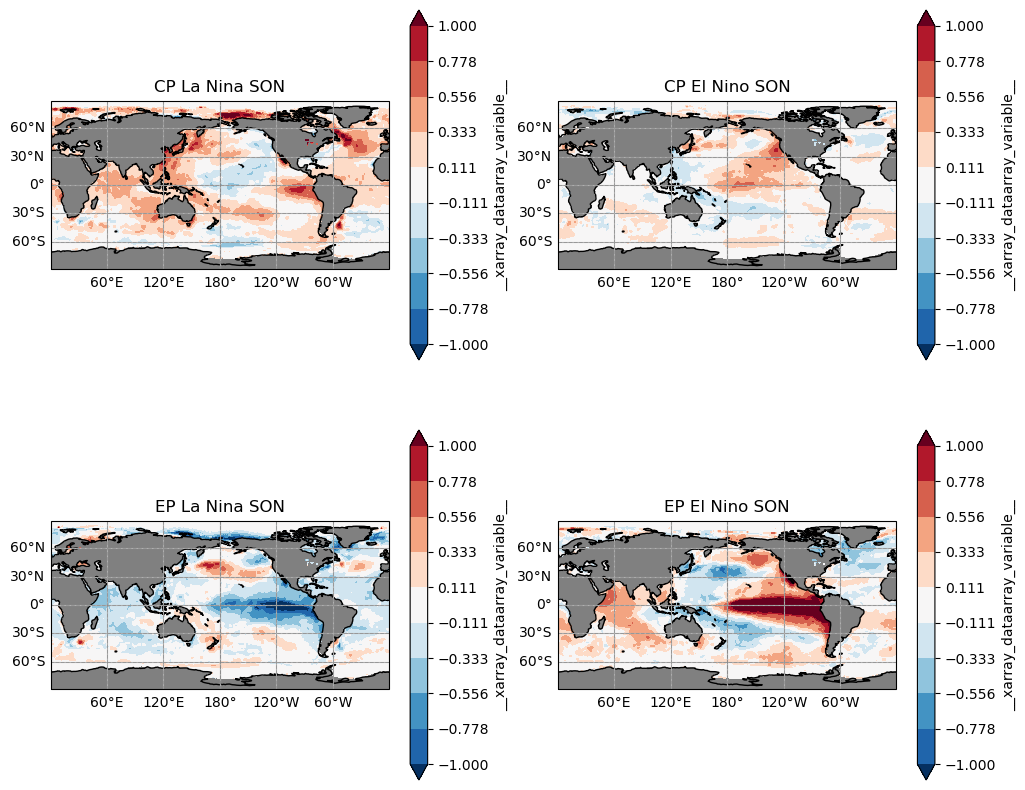

In [54]:
# Create a figure with 4 subplots
fig = plt.figure(figsize=(12, 10))

# Call the function for each subplot
plot_comp(CPl_SON, "CP La Nina SON", 1) 
plot_comp(CPe_SON, "CP El Nino SON", 2) 
plot_comp(EPl_SON, "EP La Nina SON", 3) 
plot_comp(EPe_SON, "EP El Nino SON", 4) 

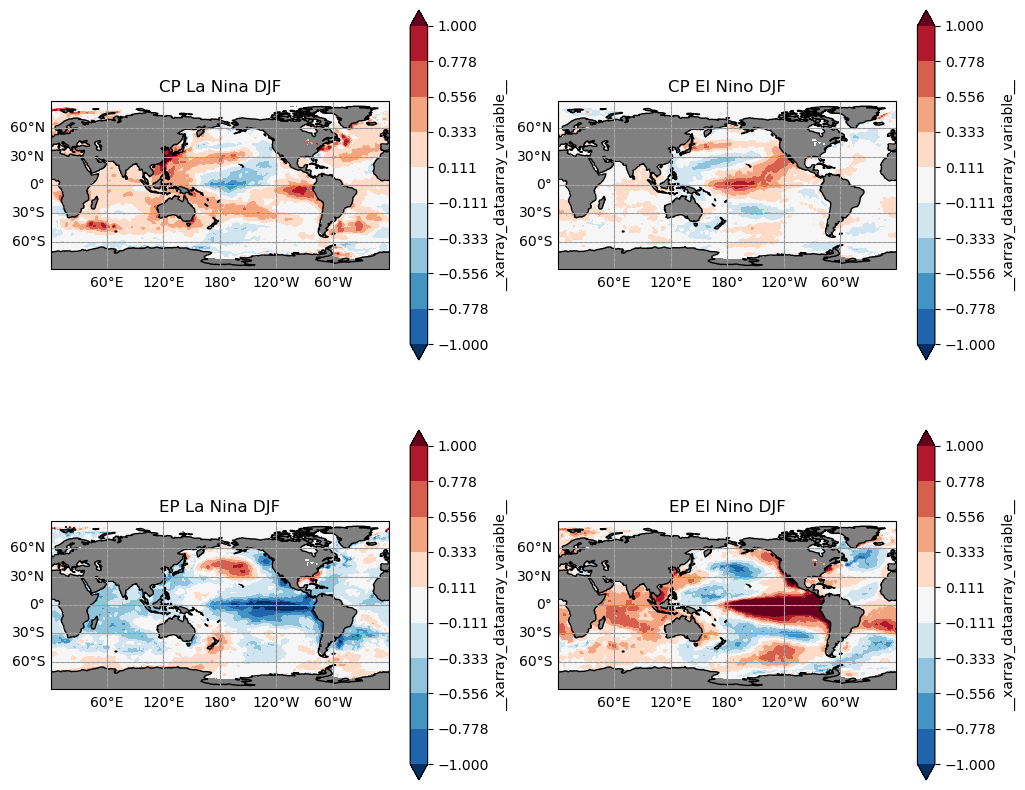

In [55]:
# Create a figure with 4 subplots
fig = plt.figure(figsize=(12, 10))

# Call the function for each subplot
plot_comp(CPl_DJF, "CP La Nina DJF", 1) 
plot_comp(CPe_DJF, "CP El Nino DJF", 2) 
plot_comp(EPl_DJF, "EP La Nina DJF", 3) 
plot_comp(EPe_DJF, "EP El Nino DJF", 4) 

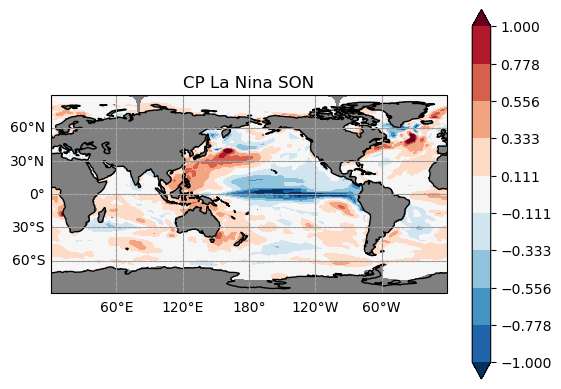

In [137]:
plot_comp(CPl_SON, "CP La Nina SON")

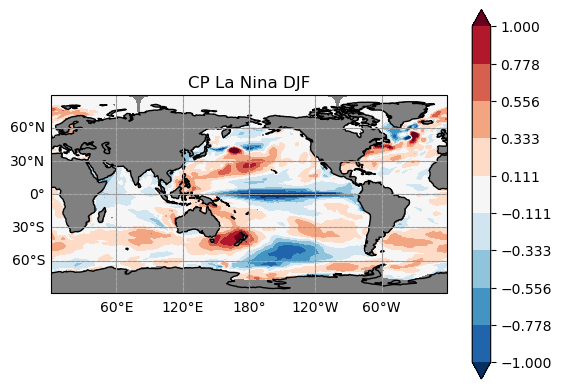

In [138]:
plot_comp(CPl_DJF, "CP La Nina DJF")

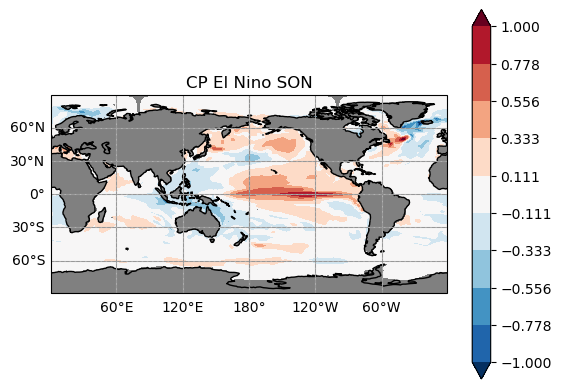

In [139]:
plot_comp(CPe_SON, "CP El Nino SON")

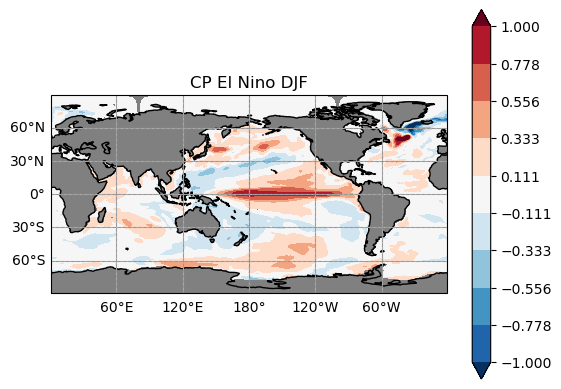

In [136]:
plot_comp(CPe_DJF, "CP El Nino DJF")

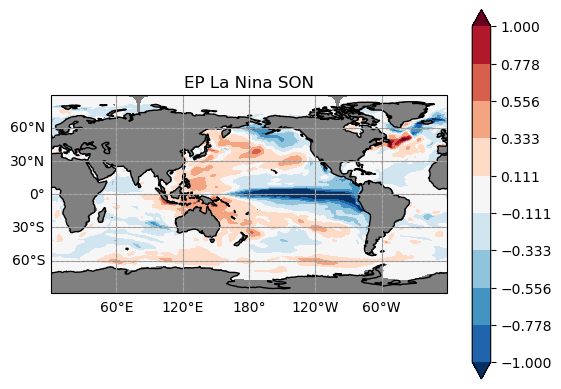

In [145]:
plot_comp(EPl_SON, "EP La Nina SON")

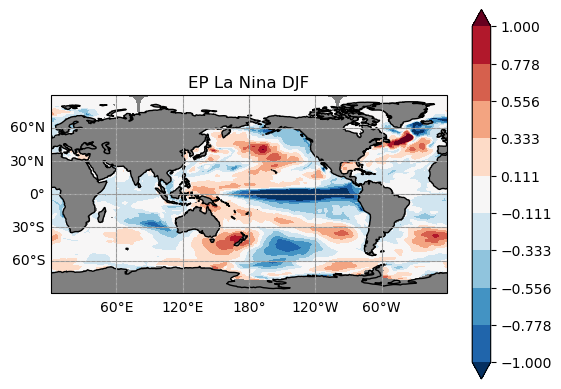

In [146]:
plot_comp(EPl_DJF, "EP La Nina DJF")

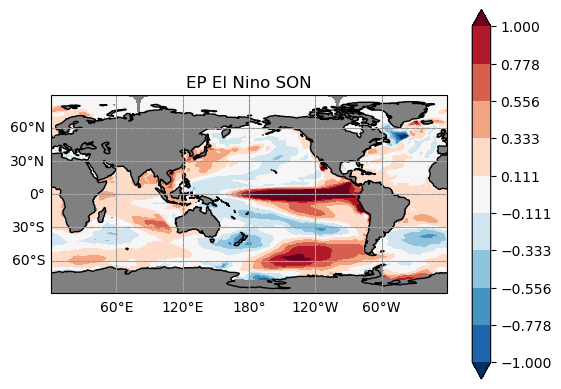

In [147]:
plot_comp(EPe_DJF, "EP El Nino SON")

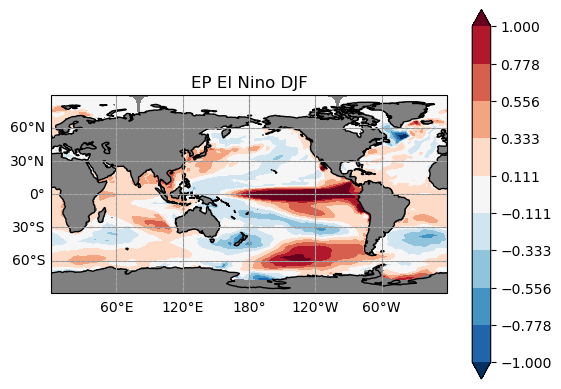

In [148]:
plot_comp(EPe_DJF, "EP El Nino DJF")

In [90]:
l3_lmod=[]
for year in lm.groupby("time.year").mean("time").year.values:
    if year in l3.groupby("time.year").mean("time").year.values:
        l3_lmod.append(year)
print(l3_lmod)

[952, 959, 977, 983, 996, 1000, 1010, 1015, 1022, 1027, 1053, 1055, 1073, 1078, 1081, 1089, 1097, 1103, 1109, 1120, 1128, 1137, 1146]


In [83]:
piod_emod=[]
for year in piod.groupby("time.year").mean("time").year.values:
    if year in em.groupby("time.year").mean("time").year.values:
        piod_emod.append(year)
print(piod_emod)

[963, 991, 992, 1009, 1012, 1041, 1064, 1134, 1145]


In [84]:
piod_e3=[]
for year in piod.groupby("time.year").mean("time").year.values:
    if year in e3.groupby("time.year").mean("time").year.values:
        piod_e3.append(year)
print(piod_e3)

[951, 958, 999, 1014, 1017, 1037, 1059, 1119, 1127, 1138, 1145]


In [85]:
niod_lmod=[]
for year in niod.groupby("time.year").mean("time").year.values:
    if year in lm.groupby("time.year").mean("time").year.values:
        niod_lmod.append(year)
print(niod_lmod)

[1053, 1081, 1097, 1101, 1109, 1120, 1137, 1141]


In [86]:
niod_l3=[]
for year in niod.groupby("time.year").mean("time").year.values:
    if year in l3.groupby("time.year").mean("time").year.values:
        niod_l3.append(year)
print(niod_l3)

[994, 1051, 1053, 1081, 1097, 1109, 1120, 1133, 1137]


In [ ]:
#use these year lists to make composites

In [75]:
l3_yrs = l3.groupby("time.year").mean("time")

In [76]:
lm_yrs = lm.groupby("time.year").mean("time")

In [77]:
e3_yrs = e3.groupby("time.year").mean("time")

In [78]:
em_yrs = em.groupby("time.year").mean("time")

In [79]:
test = em_yrs.where(em_yrs.year != e3_yrs.year)

In [87]:
test = lm_yrs.where(lm_yrs.year != l3_yrs.year)

In [88]:
test

<xarray.DataArray (year: 13)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)
Coordinates:
  * year     (year) int64 959 977 996 1010 1015 ... 1089 1109 1128 1137 1146

In [91]:
nino3_only_events = em_yrs.year.where(~e3_yrs.year, drop=True)

In [92]:
nino3_only_events

<xarray.DataArray 'year' (year: 1)>
array([1142.])
Coordinates:
  * year     (year) int64 1142

In [83]:
lm_yrs.year

<xarray.DataArray 'year' (year: 24)>
array([ 952,  959,  977,  996, 1000, 1010, 1015, 1027, 1053, 1055, 1078, 1081,
       1089, 1097, 1103, 1109, 1112, 1114, 1120, 1122, 1128, 1137, 1141, 1146])
Coordinates:
  * year     (year) int64 952 959 977 996 1000 1010 ... 1122 1128 1137 1141 1146

In [84]:
l3_yrs.year

<xarray.DataArray 'year' (year: 18)>
array([ 959,  977,  983,  996, 1010, 1015, 1027, 1030, 1051, 1055, 1069, 1078,
       1089, 1109, 1118, 1128, 1137, 1146])
Coordinates:
  * year     (year) int64 959 977 983 996 1010 1015 ... 1109 1118 1128 1137 1146

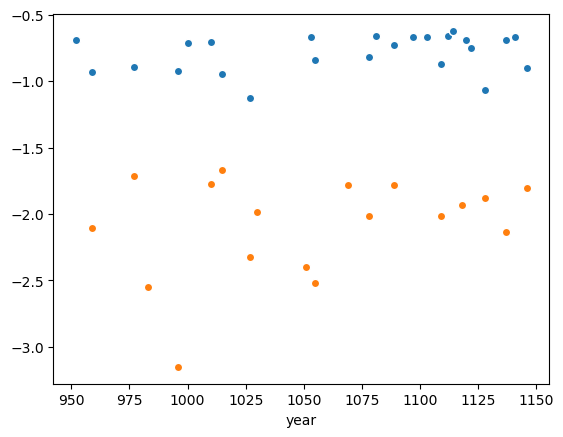

In [80]:
lm_yrs.plot.scatter()
l3_yrs.plot.scatter()

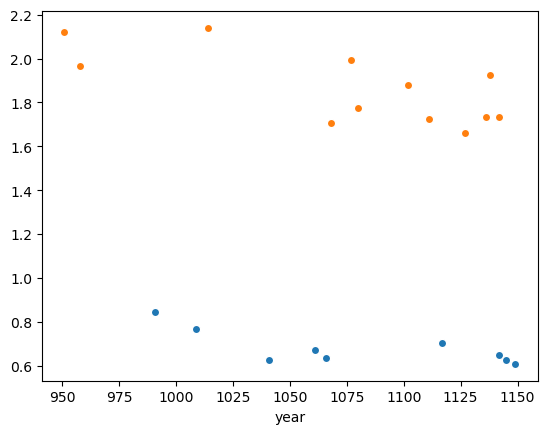

In [72]:
em_yrs.plot.scatter()
e3_yrs.plot.scatter()

In [49]:
em_yrs

<xarray.DataArray 'year' (year: 9)>
array([ 991, 1009, 1041, 1061, 1066, 1117, 1142, 1145, 1149])
Coordinates:
  * year     (year) int64 991 1009 1041 1061 1066 1117 1142 1145 1149

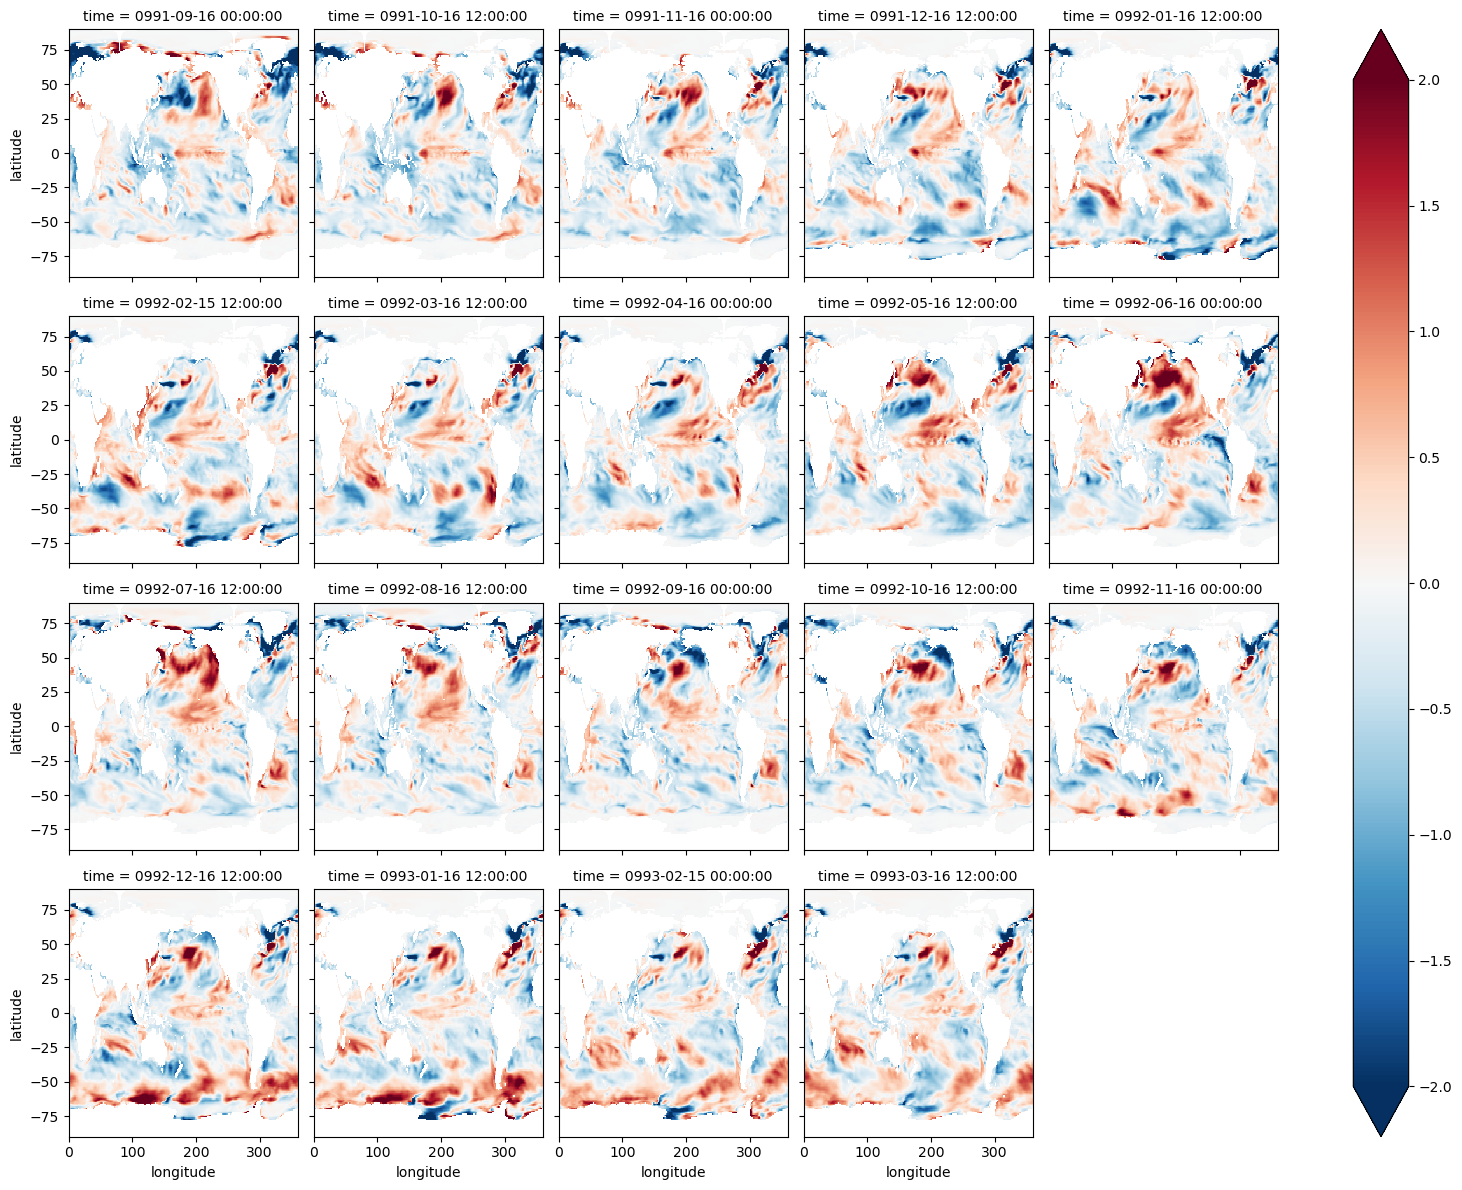

In [21]:
ssta(ctrl).sel(time = slice("0991-09-01", "0993-03-31")).plot(col = "time", col_wrap = 5, vmin = -2, vmax = 2, cmap = "RdBu_r")

In [ ]:
def get_events(ds):
    threshold = ds.groupby("time.month")

In [17]:
def plot_comp(da, title, subplot_index):
    # Define the subplot layout (2 rows, 2 columns)
    plt.subplot(2, 2, subplot_index, projection=ccrs.PlateCarree(central_longitude=180))
    
    da.mean("year").plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r")
    
    plt.title(title)
    plt.gca().coastlines(color='k')
    plt.gca().gridlines()
    plt.gca().set_facecolor('grey')
    gl = plt.gca().gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False



In [18]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [19]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['time'], ['time']],# reduce along 'model'
                        )
    return slope

In [ ]:
#create figure with regtrssion of 4 plots
fig = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
    
regress(mod, ssta(ctrl)).plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r")
    
plt.title("CP ENSO SSTA regression ACCESS-CM2")
plt.gca().coastlines(color='k')
plt.gca().gridlines()
plt.gca().set_facecolor('grey')
gl = plt.gca().gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
regress(n3, ssta(ctrl)).plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r")
    
plt.title("EP ENSO SSTA regression ACCESS-CM2")
plt.gca().coastlines(color='k')
plt.gca().gridlines()
plt.gca().set_facecolor('grey')
gl = plt.gca().gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))

regress(modh, ssta(had)).plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r")
    
plt.title("CP ENSO SSTA regression HadISST")
plt.gca().coastlines(color='k')
plt.gca().gridlines()
plt.gca().set_facecolor('grey')
gl = plt.gca().gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
    
regress(n3h, ssta(had)).plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r")
    
plt.title("EP ENSO SSTA regression HadISST")
plt.gca().coastlines(color='k')
plt.gca().gridlines()
plt.gca().set_facecolor('grey')
gl = plt.gca().gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

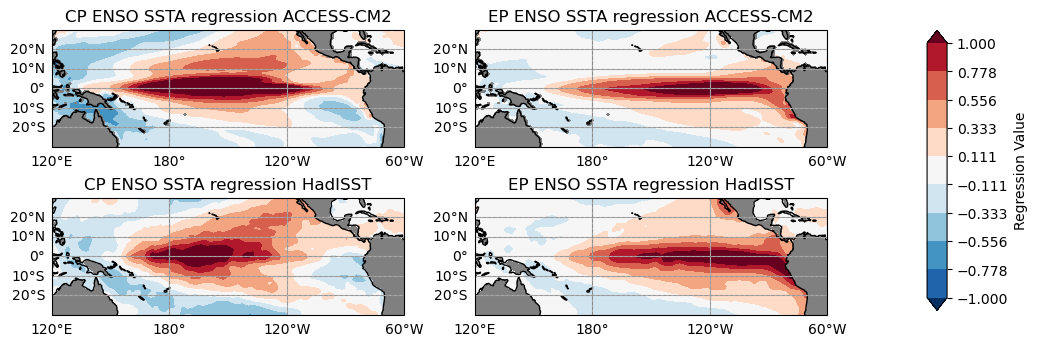

In [32]:
# Create figure with 2x2 grid of subplots
fig = plt.figure(figsize=(10, 4))

# Create a list to store the contourf objects for each subplot
contourf_objs = []

# Loop through each subplot
for i, (data, sst, title) in enumerate([(mod, ctrl, "CP ENSO SSTA regression ACCESS-CM2"),
                                  (n3, ctrl, "EP ENSO SSTA regression ACCESS-CM2"),
                                  (modh, had, "CP ENSO SSTA regression HadISST"),
                                  (n3h, had, "EP ENSO SSTA regression HadISST")]):

    ax = plt.subplot(2, 2, i + 1, projection=ccrs.PlateCarree(central_longitude=180))
    
    # Calculate the regression and plot it with contourf
    cf = regress(data, ssta(sst)).plot.contourf(transform=ccrs.PlateCarree(),
                            vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)
    
    plt.title(title)
    ax.coastlines(color='k')
    ax.gridlines()
    ax.set_facecolor('grey')
    ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    contourf_objs.append(cf)

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(contourf_objs[0], cax=cbar_ax)
cbar.set_label('Regression Value')

#plt.tight_layout()
plt.show()

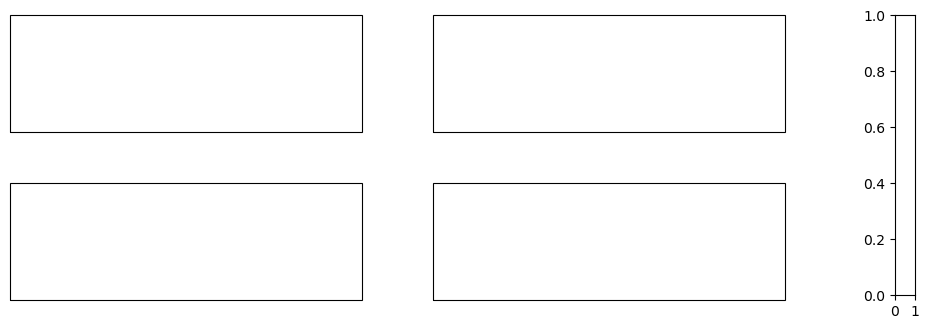

In [31]:
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
ax = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())

ax = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())

ax = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())

cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  # Adjust the position and size as needed


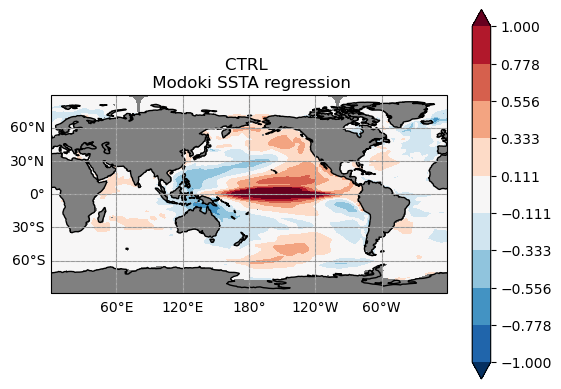

In [55]:
slope = regress(mod, ssta(ctrl))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n Modoki SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

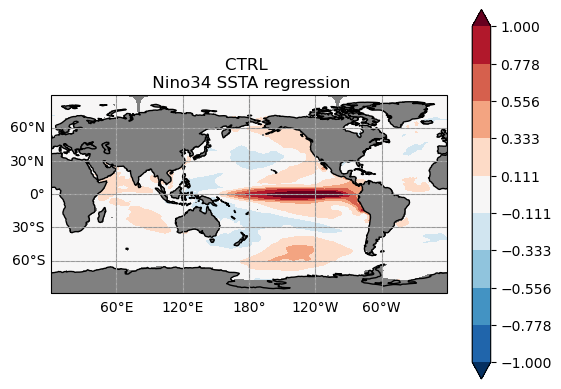

In [24]:
slope = regress(n34, ssta(ctrl))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n Nino34 SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

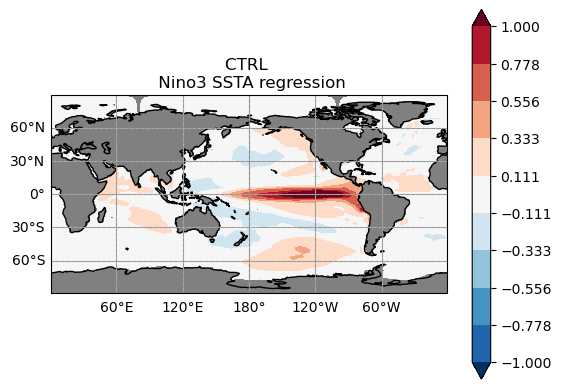

In [25]:
slope = regress(n3, ssta(ctrl))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n Nino3 SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

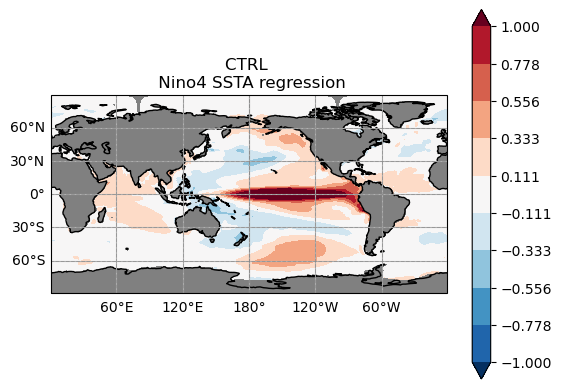

In [26]:
slope = regress(n4, ssta(ctrl))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n Nino4 SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

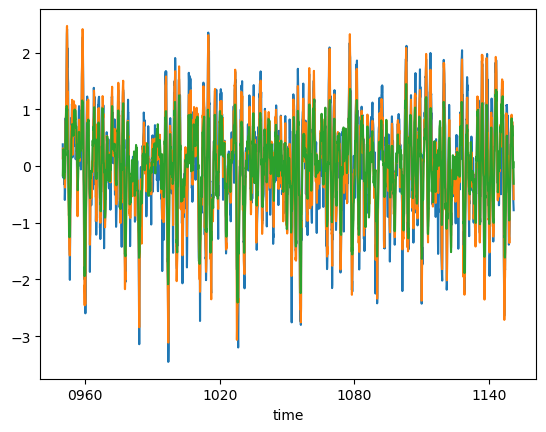

In [21]:
#look at SSTA regression of the indexes

In [66]:
n3.resample(time='QS-DEC').mean("time").groupby("time.season")['DJF']#.groupby('time.year').mean("time")

<xarray.DataArray (time: 202)>
array([ 0.22650114, -0.43965244,  2.1226206 , -1.3334647 ,  0.86316186,
        0.84392476,  0.42894813,  0.50785995,  0.14126591,  1.9681503 ,
       -2.105425  ,  1.1548429 , -1.0018979 , -0.28045022,  1.0020558 ,
       -0.9782035 ,  1.1848005 , -0.56466943,  0.9240198 , -0.46664155,
        0.26580784, -0.00732606,  1.0741334 ,  0.5437165 , -0.7188661 ,
        1.0858026 , -0.7153594 ,  1.3167573 , -1.7124    ,  0.9500877 ,
       -1.0443906 , -0.20369916, -0.18148358, -0.17855944, -2.5522597 ,
       -0.35160303,  0.69189566,  0.25305894,  0.12575161, -0.28331816,
        0.48449194,  0.4445629 , -0.14780983,  0.04334655, -0.5672064 ,
       -1.1249448 ,  1.5142499 , -3.151614  ,  0.64626724, -0.57619184,
        1.5973266 , -1.2851039 ,  1.2443991 , -0.7827801 , -0.6157992 ,
       -0.01790244,  0.82407314,  1.0483317 , -0.16179615,  0.13964806,
        0.6631988 , -1.7774228 , -0.25529525,  1.076984  , -1.306691  ,
        2.1395931 , -1.6687994 , -0.60161465,  1.1312665 , -0.3937188 ,
        0.88377285,  0.8643796 ,  0.27432767, -1.2029768 ,  0.1736695 ,
       -0.40350318,  0.46534118,  1.4742966 , -2.3267202 , -0.06620368,
        0.8559494 , -1.9829696 ,  0.16380109,  0.75701505, -0.43931285,
        1.1876001 ,  0.23186554, -0.44595233,  1.4854339 , -0.9197039 ,
        0.6040521 , -0.6099016 ,  0.5386067 ,  0.03691068, -0.88700765,
        0.939981  , -0.21416534,  0.3583168 , -0.30913797,  0.48685804,
...
        0.7459853 , -2.5191    ,  1.0807687 ,  0.19084515, -0.9886725 ,
        1.1450146 , -0.8405592 ,  1.1969377 , -0.22046411, -0.3404959 ,
        0.38588083, -0.49765038,  0.6881304 , -1.2075987 ,  1.7078937 ,
       -1.7817621 ,  1.2489873 , -0.67080325,  0.38187996, -1.3751973 ,
        0.36622342,  0.33726844, -0.1672932 ,  1.9946524 , -2.0128095 ,
       -0.04746254,  1.7738123 , -1.4453398 ,  0.84482354,  0.21113306,
       -0.75532943,  0.7981532 ,  0.28331086,  0.92824775, -0.04284285,
       -1.7821077 ,  0.834764  ,  1.1091008 , -0.22076184,  0.4612762 ,
       -0.37635627, -0.8706561 ,  0.42892036, -1.1893134 ,  0.24433218,
        0.61054033, -0.27611086, -0.92290014,  1.8800058 , -1.2325892 ,
        0.9059682 , -0.33070567,  1.0389527 , -0.87567395,  1.2283446 ,
       -2.0173628 ,  0.47257265,  1.7231661 , -0.6070481 ,  1.5430223 ,
       -0.3463005 , -0.01548972, -0.26458135,  0.16169912, -1.9337758 ,
        1.5944262 , -1.3260945 ,  0.45211196, -1.014431  , -0.30511102,
       -0.8144614 ,  0.15544434,  0.05380094,  1.6608604 , -1.8784728 ,
        1.0017942 , -1.000708  ,  0.31526816, -0.631896  , -1.2745003 ,
        1.0651191 , -0.95172375,  1.7340981 , -2.1372056 ,  1.9229374 ,
       -1.0208825 ,  1.0268174 , -1.0144941 ,  1.7353922 , -0.09952403,
        0.50537115,  1.3337654 , -1.8061231 ,  0.89219993, -1.2642616 ,
        0.73970485, -0.7794932 ], dtype=float32)
Coordinates:
  * time     (time) object 0949-12-01 00:00:00 ... 1150-12-01 00:00:00

In [97]:
def events(ds, peak_seas):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = ds.resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    seas = QS.groupby('time.season')[peak_seas]
    #now use this to select all events and create da's of niod and piod event values
    threshold = seas.std()
    
    lower,upper = seas.quantile([0.2, 0.8])
    
    
    LN = seas.where(seas <= -1.5*threshold).dropna(dim = "time")
    EN = seas.where(seas >= 1.5*threshold).dropna(dim = "time")
    return LN, EN


In [98]:
#get IOD events

In [109]:
l3, e3 = events(n3, "DJF")
lm, em = events(mod, "DJF")

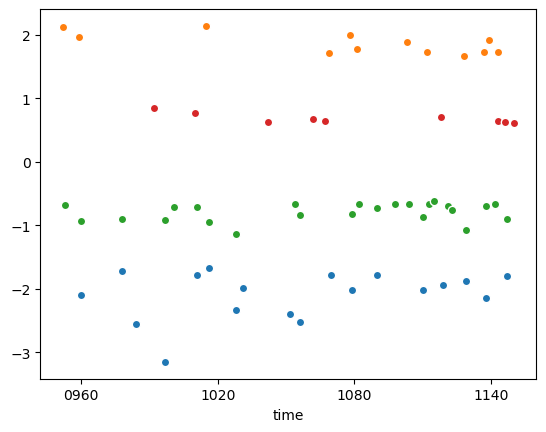

In [110]:
#dmi.resample(time='QS-DEC').mean(dim="time").plot()
l3.plot.scatter()
e3.plot.scatter()
lm.plot.scatter()
em.plot.scatter()

In [74]:
def get_event_times(ds_sst, peak_seas, ds_var, season):
    LN, EN = events(ds_sst, peak_seas)
    #now get the times where the variable is in SON
    DJF_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby('time.season')[season].groupby("time.year").mean("time")
    #Now use nIOd and PIOD to get the times that we want
    LN_var = DJF_var.where(DJF_var.year == LN.groupby("time.year").mean("time").year)#.dropna(dim = "time")
    EN_var = DJF_var.where(DJF_var.year == EN.groupby("time.year").mean("time").year)#.dropna(dim = "time")
    return LN_var, EN_var

In [85]:
L4e, E4e = get_event_times(dmi, "SON", ssta(ctrl), "SON")

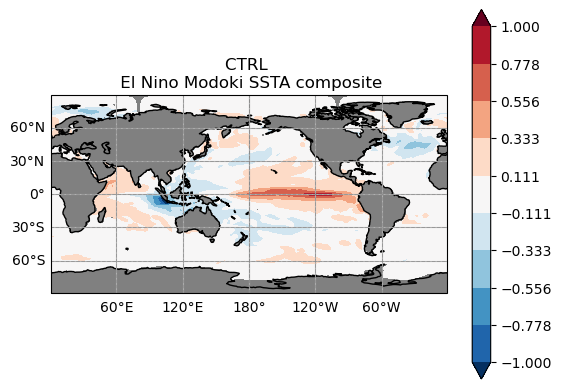

In [86]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

E4e.mean("year").plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n El Nino Modoki SSTA composite')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

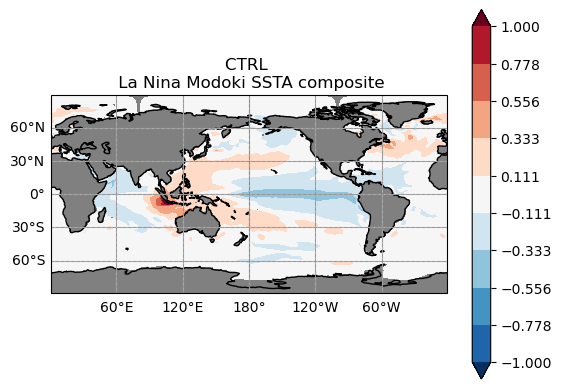

In [87]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

L4e.mean("year").plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n La Nina Modoki SSTA composite')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

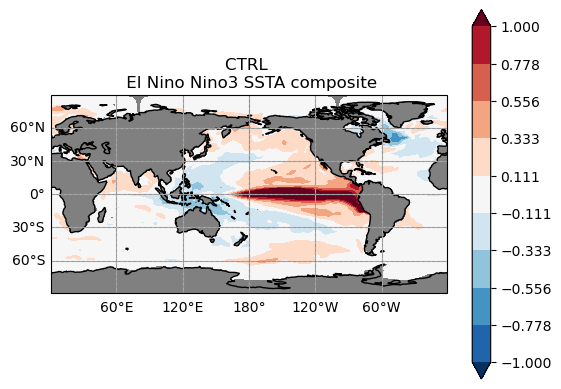

In [81]:
L4e, E4e = get_event_times(n3, "DJF", ssta(ctrl), "SON")
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

E4e.mean("year").plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n El Nino Nino3 SSTA composite')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

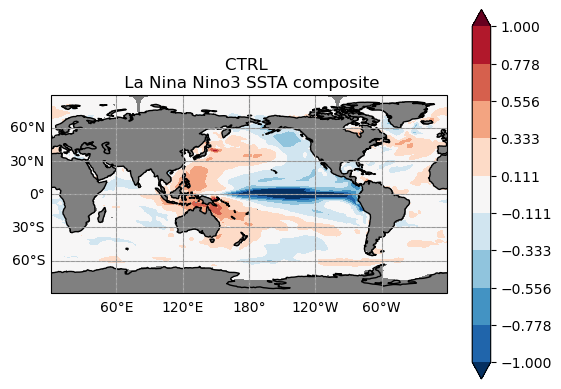

In [82]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

L4e.mean("year").plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n La Nina Nino3 SSTA composite')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

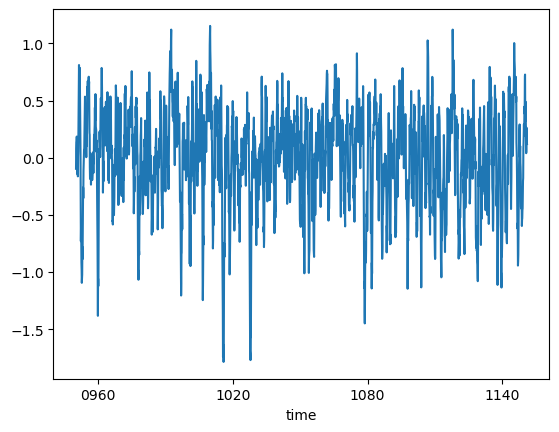

In [62]:
mod.plot()

In [36]:
DJF_var = ctrl.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]


In [40]:
DJF_var.where(DJF_var.time == L4.time)#.dropna(dim = "time")

<xarray.DataArray (time: 51, latitude: 180, longitude: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7024755, -1.7022195, -1.7019624, ..., -1.703269 ,
         -1.7029833, -1.7027303],
        [-1.6996007, -1.6994857, -1.6993723, ..., -1.699955 ,
         -1.6998354, -1.6997172],
        [-1.7043203, -1.7043257, -1.7043327, ..., -1.7043132,
         -1.7043139, -1.7043163]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.75532  , -1.7557969, -1.75627  , ..., -1.7538725,
         -1.7543567, -1.7548398],
        [-1.752066 , -1.75219  , -1.7523093, ..., -1.7516669,
         -1.751804 , -1.751937 ],
        [-1.7447296, -1.7447265, -1.7447218, ..., -1.7447301,
         -1.7447315, -1.7447314]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7439132, -1.7443486, -1.7447796, ..., -1.7426115,
         -1.7430291, -1.743473 ],
        [-1.7400799, -1.7401727, -1.7402626, ..., -1.7397861,
         -1.7398866, -1.7399845],
        [-1.7362818, -1.7362608, -1.7362396, ..., -1.7363405,
         -1.7363214, -1.7363018]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) object 0952-12-01 00:00:00 ... 1148-12-01 00:00:00
Attributes:
    regrid_method:  bilinear

In [96]:
test_t = xr.open_dataset("/g/data/e14/sm2435/CMIP6/CMIP6/EC-Earth3/thetao/thetao_Omon_EC-Earth3_historical_r1i1p1f1_gn_185001-185012.nc")


In [140]:
test_u = xr.open_dataset("/g/data/e14/sm2435/CMIP6/CMIP6/EC-Earth3/uo_new/uo_Omon_EC-Earth3_historical_r1i1p1f1_gn_185001-185012.nc")


In [98]:
test_t = test_t.thetao

In [141]:
test_u = test_u.uo

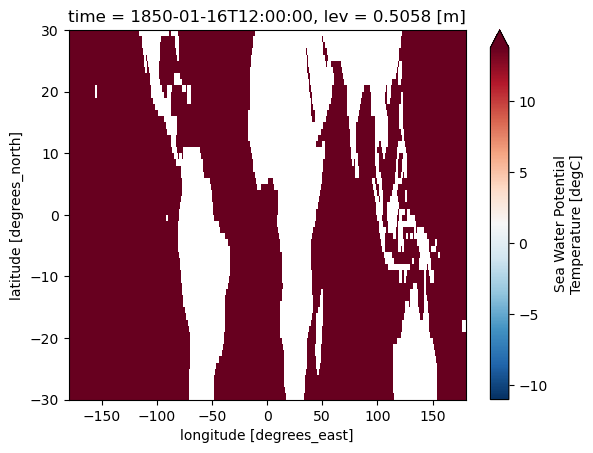

In [104]:
test_t[0,0].plot(vmax = -10, cmap = "RdBu_r")

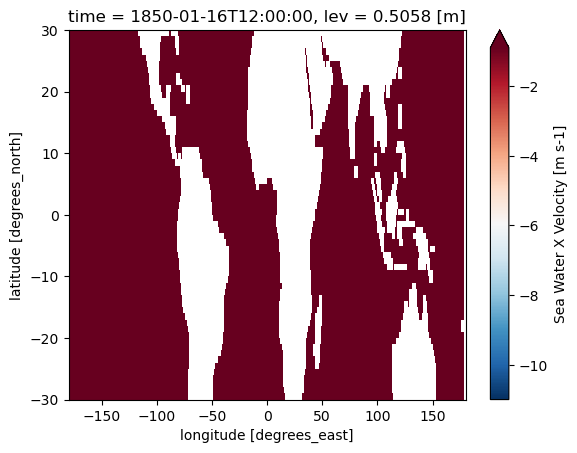

In [166]:
u_shifted[0,0].plot(vmax = -10, cmap = "RdBu_r")

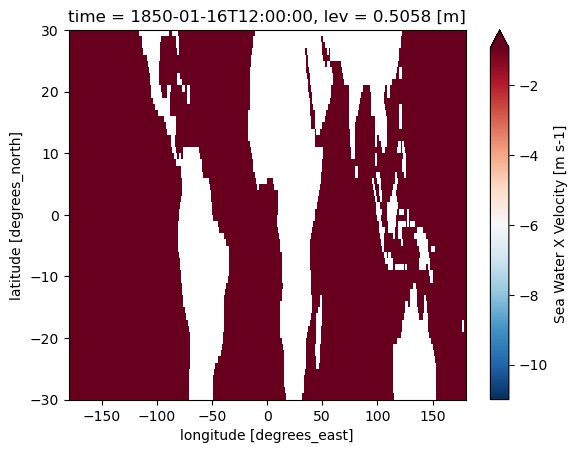

In [142]:
test_u[0,0].plot(vmax = -10, cmap = "RdBu_r")

In [173]:
test_t[0,0,10,140].values

array(nan)

In [170]:
test_u[0,0,10,140].values

array(-0.00356406)

In [172]:
u_shifted[0,0,10,141].values

array(-0.02438816)

In [54]:
test_t[0,0,100,42].values

array(21.83348465)

In [55]:
test_u[0,0,100,42].values

array(0.)

In [62]:
test_u.coords

Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...

In [58]:
test_u_shifted = test_u.shift(i=1)

In [61]:
test_u_shifted[0,0,100,82].values

array(-0.04743022, dtype=float32)

In [161]:
u = test_u

In [164]:
half_grid_cell_width = 0.5  # Replace with the actual grid cell width
shifted_longitude = (u.lon + half_grid_cell_width)# % 360
u_shifted = u.interp(lon=shifted_longitude)
u_shifted = u_shifted.assign_coords(longitude=u.lon)


In [165]:
u_shifted

<xarray.DataArray 'uo' (time: 12, lev: 21, lat: 60, lon: 360)>
array([[[[ 6.79004192e-03,  5.15989983e-03,  1.92082510e-03, ...,
          -2.27554771e-03,  3.56380630e-03,             nan],
         [-9.04675038e-03, -1.14847338e-02, -1.26819327e-02, ...,
          -7.62829906e-03, -5.52129024e-03,             nan],
         [-1.09402509e-02, -1.13784582e-02, -1.00022545e-02, ...,
          -6.79874793e-03, -7.43323355e-03,             nan],
         ...,
         [ 2.23636311e-02,  2.06580563e-02,  1.92372864e-02, ...,
           2.43062992e-02,  2.43471004e-02,             nan],
         [ 2.74963947e-02,  2.45322250e-02,  2.13913312e-02, ...,
           2.96516102e-02,  2.98371203e-02,             nan],
         [ 3.92311737e-02,  3.65419313e-02,  3.22660832e-02, ...,
           3.89122628e-02,  3.98403015e-02,             nan]],

        [[ 7.89909391e-03,  6.29677670e-03,  3.21885548e-03, ...,
          -7.82068819e-04,  4.92740120e-03,             nan],
         [-7.78474612e-03, -1.02730575e-02, -1.15053705e-02, ...,
          -6.00550766e-03, -4.04494372e-03,             nan],
         [-9.55960853e-03, -9.96325631e-03, -8.55580275e-03, ...,
          -5.25453407e-03, -5.97002963e-03,             nan],
...
         [-3.91891645e-03, -2.41746090e-03, -1.34103512e-03, ...,
          -9.96179227e-03, -9.65695782e-03,             nan],
         [ 7.87765486e-03,  1.03650116e-02,  1.05926665e-02, ...,
           5.83325687e-04,  1.98238948e-03,             nan],
         [ 2.22442020e-02,  2.58588521e-02,  2.93967538e-02, ...,
           1.52132176e-02,  1.81758525e-02,             nan]],

        [[ 1.86169092e-02,  1.81827927e-02,  1.71783306e-02, ...,
           1.17446110e-02,  1.54549880e-02,             nan],
         [ 1.16975731e-02,  1.03235655e-02,  9.08075459e-03, ...,
           1.04867262e-02,  1.21189305e-02,             nan],
         [ 7.01337052e-03,  5.80857880e-03,  5.31575922e-03, ...,
           9.97467805e-03,  9.68414778e-03,             nan],
         ...,
         [-8.85747327e-03, -7.45333987e-03, -5.92694338e-03, ...,
          -1.22484448e-02, -1.12841474e-02,             nan],
         [ 3.13388044e-03,  5.16355294e-03,  6.61535212e-03, ...,
          -2.14448886e-03, -2.27422337e-04,             nan],
         [ 2.14802790e-02,  2.30983719e-02,  2.41375612e-02, ...,
           1.41562768e-02,  1.71027966e-02,             nan]]]])
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12:00:00
  * lat        (lat) float64 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lev        (lev) float64 0.5058 1.556 2.668 3.856 ... 53.85 61.11 69.02
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    longitude  (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_water_x_velocity
    long_name:      Sea Water X Velocity
    units:          m s-1
    comment:        Prognostic x-ward velocity component resolved by the model.
    original_name:  uo
    cell_methods:   time: mean
    history:        2019-09-26T09:16:29Z altered by CMOR: Reordered dimension...

In [76]:
u_shifted = u.interp(i=shifted_longitude)

In [95]:
test_u[0,0,100,80].longitude.values

array(153.)

In [89]:
u_shifted[0,0,100,80]

<xarray.DataArray 'uo' ()>
array(-0.02371511)
Coordinates:
    time       datetime64[ns] 1850-01-16T12:00:00
    lev        float64 0.5058
    j          int32 101
    latitude   float64 -29.59
    longitude  float64 153.5
    i          int32 81
Attributes:
    standard_name:  sea_water_x_velocity
    long_name:      Sea Water X Velocity
    comment:        Prognostic x-ward velocity component resolved by the model.
    units:          m s-1
    original_name:  uo
    cell_methods:   time: mean
    history:        2019-09-26T09:16:29Z altered by CMOR: Reordered dimension...